In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from itertools import combinations

from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

# for pie charts
import plotly.express as px
import plotly.graph_objects as go

In [2]:
cmap_label = plt.get_cmap('tab20b', 18)
FID_colors = cmap_label(np.linspace(0, 1, 18))

FID_colors[0, :] = np.array([0, 0, 0.5, 1]) # AR
FID_colors[1, :] = np.array([0, 0.7, 0.7, 1]) # Front
FID_colors[2, :] = np.array([1, 1, 0, 1]) # MCS
FID_colors[3, :] = np.array([1, 0, 0, 1]) # LPS

FID_colors[4, :] = (FID_colors[0, :] + FID_colors[1, :])/2 # AF
FID_colors[5, :] = (FID_colors[0, :] + FID_colors[2, :])/2 # AM
FID_colors[6, :] = (FID_colors[0, :] + FID_colors[3, :])/2  # AL
FID_colors[7, :] = (FID_colors[1, :] + FID_colors[2, :])/2  # FM
FID_colors[8, :] = (FID_colors[1, :] + FID_colors[3, :])/2  # FL
FID_colors[9, :] = (FID_colors[2, :] + FID_colors[3, :])/2  # ML

FID_colors[10, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[2, :])/3 # AFM
FID_colors[11, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[3, :])/3 # AFL
FID_colors[12, :] = (FID_colors[0, :] + FID_colors[2, :] + FID_colors[3, :])/3  # AML
FID_colors[13, :] = (FID_colors[1, :] + FID_colors[2, :] + FID_colors[3, :])/3  # FML
FID_colors[14, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[2, :] + FID_colors[3, :])/4  # All

# UE, DC, CG
FID_colors[15, :] =  np.array([192/255, 192/255, 192/255, 1]) # UE
FID_colors[16, :] =  np.array([255/255, 51/255, 153/255, 1]) # DC
FID_colors[17, :] =  np.array([255/255, 51/255, 255/255, 1]) # CG

FID_cmp = ListedColormap(FID_colors)

In [4]:
FID_label = ['AR','FT','MCS','LPS','AF','AM','AL','FM','FL','ML','AFM','AFL','AML','FML','All','UE','DC','CG']

# generate colormap for the pie chart with colors corresponding to feature maps
# check color_discrete_sequence=px.colors.sequential.RdBu (https://plotly.com/python/pie-charts/)
rgb_list = []
for color_array in FID_colors:
    
    r = color_array[0]
    g = color_array[1]
    b = color_array[2]
    
    rgb_list.append('rgb({},{},{})'.format(int(r*255),int(g*255),int(b*255)))

In [5]:
warnings.filterwarnings('ignore')

### Global map of mean GPM-IMERGE precipitation

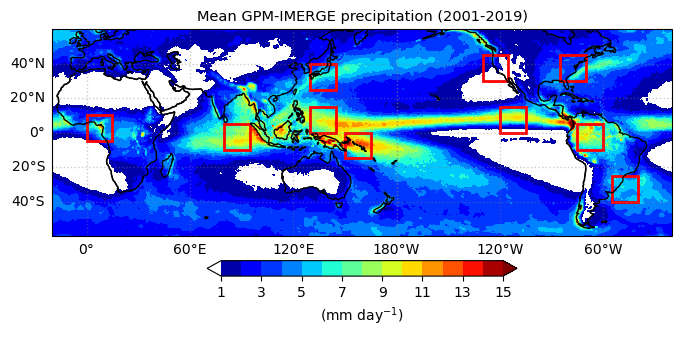

In [97]:
multi_stats_dir = Path('/neelin2020/RGMA_feature_mask/data_product/multi_year_stats/')
data_pcp_xr = xr.open_dataset(multi_stats_dir / 'gpm_mean_yearly.nc')

proj_lon_cen = 160

#fig, ax = plt.subplots(1,1,figsize=(8,4),subplot_kw={'projection': ccrs.Robinson(180)})
fig, ax = plt.subplots(1,1,figsize=(8,4),subplot_kw={'projection': ccrs.PlateCarree(proj_lon_cen)})

ax.coastlines(color='k')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='w') # maskout LAND

tmp = 24*data_pcp_xr.precipitationCal.mean('year')
tmp = tmp.where(tmp >= 1)

cf = ax.contourf(data_pcp_xr.longitude, data_pcp_xr.latitude, tmp, levels=np.linspace(1,15,15),
                cmap='jet', transform=ccrs.PlateCarree(), extend='both')
cf.cmap.set_under('w')

cbar = plt.colorbar(cf, ax=ax, shrink=0.5, pad=0.08, orientation='horizontal')
cbar.set_label('(mm day$^{-1}$)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Mean GPM-IMERGE precipitation (2001-2019)', fontsize=10.5);

## adding rectangles for targeted regions

# USNW, USNE, AMAZ, WAF, SA, IND, WPC, SPCZ, NWPC

region_sel = {
    "region": ['USNW', 'USNE', 'AMAZ', 'WAF', 'SA', 'IND', 'WPC', 'SPCZ', 'NWPC', 'EPC'],
    "lon_anc": [-130, -85, -75, 0, -55, 80, 130, 150, 130, -120],
    "lat_anc": [30, 30, -10, -5, -40, -10, 0, -15, 25, 0],
    "lon_width": [15,15,15,15,15,15,15,15,15,15],
    "lat_width": [15,15,15,15,15,15,15,15,15,15]
}

for n in range(len(region_sel['region'])):
    
    lon_anc = region_sel['lon_anc'][n]
    lat_anc = region_sel['lat_anc'][n]
    lon_width = region_sel['lon_width'][n]
    lat_width = region_sel['lat_width'][n]
        
    if (lon_anc > -180) & (lon_anc < 0):
        lon_adj = 180 + lon_anc + (180 - proj_lon_cen)
    else:
        lon_adj = lon_anc - 180 + (180 - proj_lon_cen)
    
    ax.add_patch(Rectangle((lon_adj, lat_anc),lon_width, lat_width, fc ='none', ec ='r', linewidth=2))

### Plot explanability of total rainfall / R95 & R99 extreme with pie charts

In [90]:
def explanability_pie_chart(df_regional, region_id, cmap, write_out=False, comm_name=None):
    
    """
    plot a pie chart of rainfall explanability based on a dataframe:
    df_regional: PIDs and corresponding percentage of rainfall explanability (total amount) and extreme counted
    """
    
    # process individual regions (currently 9)

    #df_regional = 100*data_regional.to_dataframe() # explained pcp (%)

    df_regional['FPID'] = np.arange(1,19) # add another column var: FPID (1-18) for sorting 
    df_regional['FPID_name'] = df_regional.index.values

    # plot pie chart    
    fig = go.Figure(data=[go.Pie(labels=df_regional['FPID_name'], 
                                  values=df_regional['pcp_explained'], 
                                  direction ='clockwise', 
                                  hole=.2, 
                                  marker_colors=cmap, 
                                  sort=True,
                                  pull=0.01,

                                  title=str(region_id))])

    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.05
    ), 
        title_x=0.47)

    fig.update_traces(
      textposition='inside',
      textinfo='label+percent',
      showlegend=False
    )

    # set font information
    fig.update_layout(font=dict(
        family='Arial',
        size=20))

    # set figure output to avoid excessive margins
    fig.update_layout(
    margin=dict(l=100, r=100, t=20, b=20))

    if write_out:

        fig.write_image('/neelin2020/RGMA_feature_mask/analysis/{}_{}.png'.format(comm_name, region_id),
                   scale=2)    
        
        print('{}_{}.png saved!'.format(comm_name, region_id))
        
    else:
        
        fig.show()
    

In [98]:
%%time
data_explained_pcp = xr.open_dataset(multi_stats_dir / 'explained_pcp_2001_2019_RmTroFT.nc')

data_region_list = []

for n in range(len(region_sel['region'])):

    lon_width = region_sel['lon_width'][n]
    lat_width = region_sel['lat_width'][n]
    
    lon_w = region_sel['lon_anc'][n]
    lon_e = region_sel['lon_anc'][n] + lon_width
    lat_s = region_sel['lat_anc'][n]
    lat_n = region_sel['lat_anc'][n] + lat_width

    if lon_w < 0:
        lon_w = 180 + (lon_w + 180)
    if lon_e < 0:
        lon_e = 180 + (lon_e + 180)

    dum = data_explained_pcp.sel(longitude=slice(lon_w, lon_e), latitude=slice(lat_s, lat_n)).mean(['year','latitude','longitude']) # over lat,lon,yr
    dum.coords['region_id'] = region_sel['region'][n]

    data_region_list.append(dum)

CPU times: user 117 ms, sys: 309 ms, total: 426 ms
Wall time: 884 ms


In [91]:
df_regional = data_region_list[0].to_dataframe()
region_id = str(data_region_list[0]['region_id'].values)

explanability_pie_chart(df_regional, region_id, 
                       cmap=rgb_list, write_out=False, comm_name='pcp_explained_pie')

In [99]:
# process individual regions (currently 9)

for n in range(len(data_region_list)):
        
    df_regional = data_region_list[n].to_dataframe()
    region_id = str(data_region_list[n]['region_id'].values)

    explanability_pie_chart(df_regional, region_id, 
                           cmap=rgb_list, write_out=True, comm_name='pcp_explained_pie')

pcp_explained_pie_USNW.png saved!
pcp_explained_pie_USNE.png saved!
pcp_explained_pie_AMAZ.png saved!
pcp_explained_pie_WAF.png saved!
pcp_explained_pie_SA.png saved!
pcp_explained_pie_IND.png saved!
pcp_explained_pie_WPC.png saved!
pcp_explained_pie_SPCZ.png saved!
pcp_explained_pie_NWPC.png saved!
pcp_explained_pie_EPC.png saved!


### extreme R95 and R99
- processed regional data by "RGMA_regional_extreme_writeout.ipynb"

In [29]:
extreme_dir = Path('/neelin2020/RGMA_feature_mask/data_product/multi_year_stats/extreme_regional')

In [86]:
data_extreme_R95 = list(extreme_dir.glob('FeatIDs_extreme_R99*'))[3]

data_region_R95 = xr.open_dataset(data_extreme_R95)

# rearrange variables for consistency 
rename_dict = {'FID': 'feature_id', 'Area': 'region_id', 'FID_nth': 'pcp_explained'}
dum = data_region_R95.mean(['year','latitude','longitude']).rename_vars(rename_dict)
dum = dum.squeeze().to_dataframe().set_index('feature_id')

df_regional_R95 = dum[['pcp_explained','region_id']]
region_id = str(data_region_R95.Area.values[0])

explanability_pie_chart(df_regional_R95, region_id, cmap=rgb_list, write_out=False)

In [100]:
# process individual regions (currently 9)

files_extreme_R95 = list(extreme_dir.glob('FeatIDs_extreme_R95*'))

for n in range(len(files_extreme_R95)):

    data_region_R95 = xr.open_dataset(files_extreme_R95[n])

    # rearrange variables for consistency 
    rename_dict = {'FID': 'feature_id', 'Area': 'region_id', 'FID_nth': 'pcp_explained'}
    dum = data_region_R95.mean(['year','latitude','longitude']).rename_vars(rename_dict)
    dum = dum.squeeze().to_dataframe().set_index('feature_id')

    df_regional_R95 = dum[['pcp_explained','region_id']]
    region_id = str(data_region_R95.Area.values[0])

    explanability_pie_chart(df_regional_R95, region_id, cmap=rgb_list, write_out=True
                            , comm_name='extremeR95_explained_pie')

RuntimeError: NetCDF: HDF error

### test for sequential colormaps (trying different ways to highlight the pcp contributions from features)

In [ ]:
cmap_label = plt.get_cmap('hot', 18)
FID_hot_colors = cmap_label(np.linspace(0, 1, 18))

rgb_hot_list = []
for color_array in FID_hot_colors:
    
    r = color_array[0]
    g = color_array[1]
    b = color_array[2]
    
    rgb_hot_list.append('rgb({},{},{})'.format(int(r*255),int(g*255),int(b*255)))

In [ ]:
df_regional_sort = df_regional.sort_values('pcp_explained', ascending=False)
    
fig = go.Figure(data=[go.Pie(labels=df_regional_sort['FPID_name'], 
                              values=df_regional_sort['pcp_explained'], 
                              direction ='clockwise', 
                              hole=.2, 
                              marker_colors=rgb_hot_list, 
                              sort=True,
                              pull=0.01,
                             
                              title='USNW')])

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.15
), 
    title_x=0.47)

fig.update_traces(
  textposition='inside',
  textinfo='label+percent'
)

fig.update_layout(font=dict(
    family='Arial',
    size=14.5))

fig.show()